In [1]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt

from torchvision import models, transforms
from PIL import Image
import config


Load the baseline model

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=False)

num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

model.load_state_dict(torch.load(config.MODEL_SAVE_PATH, map_location=device))
model.to(device)
model.eval()

print("Model loaded ")


Model loaded 


Image Preprocessing

In [4]:
transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


Load Image

In [5]:
def load_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0)
    return img, img_tensor.to(device)


In [ ]:
#Now grad cam implementation
gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

def forward_hook(module, input, output):
    global activations
    activations = output
    


In [7]:
target_layer = model.layer4
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)


Forward and Backward Pass

In [8]:
img_path = "sample_handwriting.png"  
orig_img, img_tensor = load_image(img_path)

output = model(img_tensor)
pred_class = output.item()

model.zero_grad()
output.backward()


c:\Users\ASUS\anaconda3\envs\dyslexia_env\lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [9]:
#Generate the heatmap
weights = torch.mean(gradients, dim=(2, 3))[0]

cam = torch.zeros(activations.shape[2:], dtype=torch.float32).to(device)

for i, w in enumerate(weights):
    cam += w * activations[0, i, :, :]

cam = torch.relu(cam)
cam = cam - cam.min()
cam = cam / cam.max()


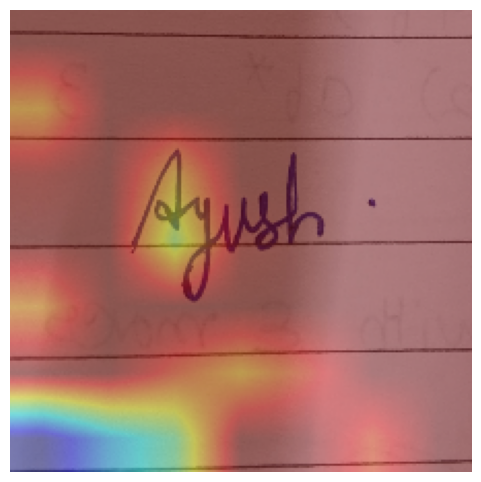

In [12]:
#Overlay the heatmap on the image

cam = cv2.resize(cam, (config.IMAGE_SIZE, config.IMAGE_SIZE))

heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

orig_img = np.array(orig_img)
orig_img = cv2.resize(orig_img, (config.IMAGE_SIZE, config.IMAGE_SIZE))
overlay = cv2.addWeighted(orig_img, 0.6, heatmap, 0.4, 0)

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.axis("off")
plt.show()
